In [ ]:
import pandas as pd
import bamt.preprocessors as pp
import matplotlib.pyplot as plt
import seaborn as sns
from bamt.networks.hybrid_bn import HybridBN
from xgboost import XGBRegressor


In [3]:
# Data processing for: cast to dataframe with columns=['x',' y', 'ice_cont']; generation of weekly data; 
# optional reduction in the number of points.

def convert(data_name, steps_fo_points=None):
    full_data = pd.read_csv('data/' + str(data_name) + '.csv', index_col=0)

    x_lon = full_data.iloc[-1]
    y_lat = full_data.iloc[-2]

    full_points = full_data.columns

    dict_xy = {str(p):[x_lon[p], y_lat[p]] for p in range(len(full_points))}

    data = full_data[:-2]

    # delete columns with 0. values
    empty_columns = []
    columns = data.columns
    for col in columns:
        unique_values = data[col].unique()
        if len(unique_values) == 1 and unique_values[0] == 0.:
            empty_columns.append(col)
    data.drop(empty_columns, axis=1, inplace=True)

    if steps_fo_points:
        keys = data.columns[::steps_fo_points]
        data = data[keys]
        dict_xy = {key: value for key, value in dict_xy.items() if key in keys}

    date_range = pd.date_range(start='2006-01-01', end='2006-12-31', freq='7d')
    year_month_day = pd.Series(date_range.format())
    month_day = [i[5:] for i in year_month_day]

    new_index = [str(i)[4:6] + '-' + str(i)[6:] for i in data.index.tolist()]
    data.index = new_index
    small_data = data.loc[month_day]

    new_df = pd.DataFrame(columns=['date', 'x', 'y', 'ice_cont'])

    len_data = len(small_data)
    for column in small_data.columns:
        ts = small_data[column]
        x = dict_xy[column][0]
        y = dict_xy[column][1]
        data = {'date': ts.index, 'x': x, 'y': y, 'ice_cont': ts.values} 
        df_to_add = pd.DataFrame(data)
        new_df = pd.concat([new_df, df_to_add])

    return new_df

In [3]:
# Formation train and test

train = convert('kar_2006-2012_with_coord', 5)
train.drop(['Unnamed: 0'], axis=1, inplace=True)
test = convert('kar_2013-2017_with_coord')
test.drop(['Unnamed: 0'], axis=1, inplace=True)
test_all_one_year = test[::5]


<b>Bayesian network with XGBoost regression </b>

In [6]:
# Form a info

full = pd.concat([train, test_all_one_year])
p = pp.Preprocessor([])
discretized_full, _ = p.apply(full)
info = p.info
info

{'types': {'date': 'disc', 'x': 'cont', 'y': 'cont', 'ice_cont': 'cont'},
 'signs': {'x': 'pos', 'y': 'pos', 'ice_cont': 'pos'}}

In [7]:
# Established structure

structure = [('date', 'ice_cont'),
             ('x', 'ice_cont'),
             ('y', 'ice_cont')]

In [8]:
# Create a Hybrid BN (as there are both discrete and continuous nodes); add nodes; add structure

bn_regr = HybridBN(has_logit=False, use_mixture=False)
bn_regr.add_nodes(info)
bn_regr.set_structure(edges=structure)


In [9]:
bn_regr.get_info()

,name,node_type,data_type,parents,parents_types
0,date,Discrete,disc,[],[]
1,x,Gaussian (LinearRegression),cont,[],[]
2,y,Gaussian (LinearRegression),cont,[],[]
3,ice_cont,ConditionalGaussian (LinearRegression),cont,"[x, y, date]","[cont, cont, disc]"


In [10]:
# Set machine learning model

bn_regr.set_regressor({'ice_cont': XGBRegressor()})

In [11]:
# Node type 'ice_cont has changed

bn_regr.get_info()

,name,node_type,data_type,parents,parents_types
0,date,Discrete,disc,[],[]
1,x,Gaussian (LinearRegression),cont,[],[]
2,y,Gaussian (LinearRegression),cont,[],[]
3,ice_cont,ConditionalGaussian (XGBRegressor),cont,"[x, y, date]","[cont, cont, disc]"


In [12]:
# Train parameters

bn_regr.fit_parameters(train)

In [115]:
# Predict ice dynamics for a year

predictions_regr_all = bn_regr.predict(test=test_all_one_year.drop(columns=['ice_cont']), parall_count=-1)

100%|██████████| 396228/396228 [11:32:01<00:00,  9.54it/s]  


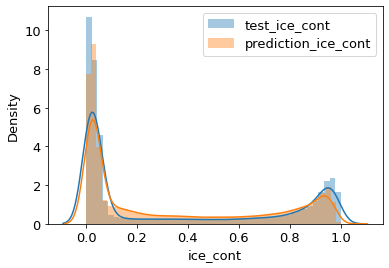

In [116]:
# Comparison of test and prediction distributions

fig, ax = plt.subplots()
sns.distplot(test_all_one_year['ice_cont'], label='test_ice_cont', ax=ax, kde=True)
sns.distplot(predictions_regr_all['ice_cont'], label='prediction_ice_cont', ax=ax, kde=True)
plt.legend() 
plt.show()

In [117]:
df_all = test_all_one_year.copy(deep=True)
df_all['ice_cont'] = predictions_regr_all['ice_cont']


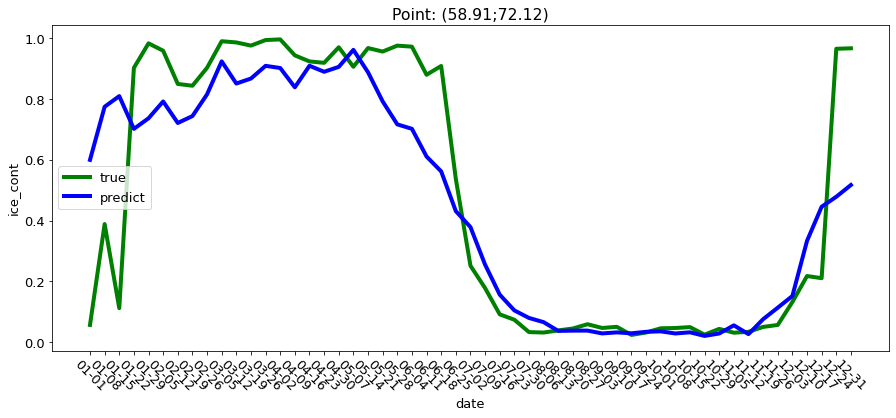

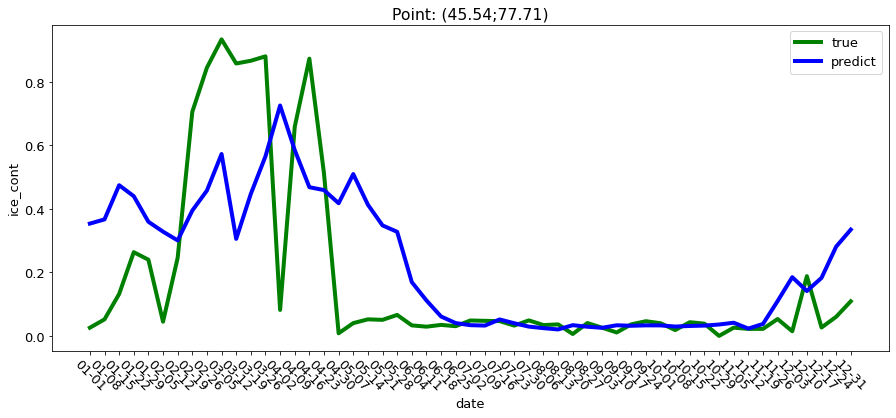

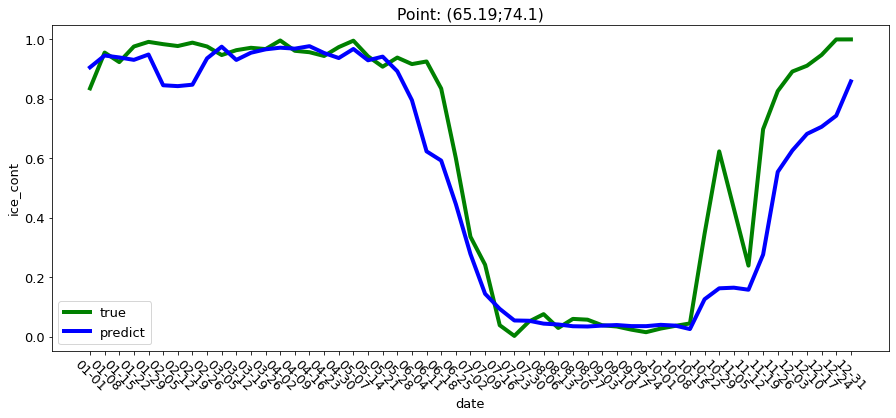

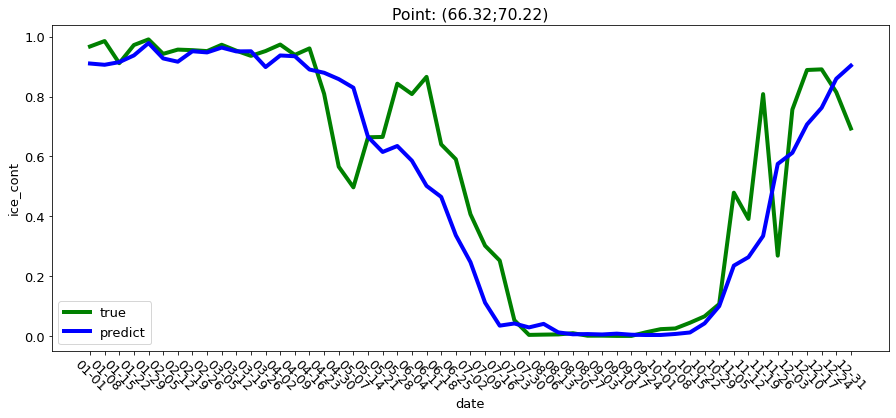

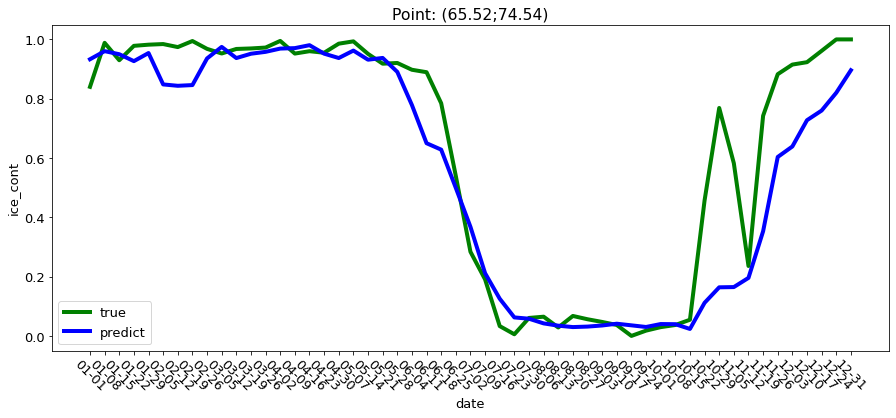

In [118]:
# Illustration of ice concentration dynamics by field points

x_y = train[['x','y']].drop_duplicates()
point_sample = x_y.sample(5)

for i in range(len(point_sample)):

    x,y = point_sample.iloc[i]
    test_plot = test_all_one_year[test_all_one_year['x'] == x]
    pred_plot = df_all[df_all['x'] == x]
    ox = test_plot['date']

    fig, ax = plt.subplots(figsize = (15, 6))
    plt.plot(ox, test_plot['ice_cont'], linewidth = 4, label = 'true', color = 'green')
    plt.plot(ox, pred_plot['ice_cont'], linewidth = 4, label = 'predict', color = 'blue')
    plt.xticks(rotation = -45)
    plt.title('Point: ' + '(' + str(round(x,2)) + ';' + str(round(y,2)) + ')')
    plt.xlabel('date')
    plt.ylabel('ice_cont')
    plt.legend()
    plt.show()